# Predicting MLB Salaries

This project builds a model using XGBoost to predict Major League Baseball (MLB) player salaries.  Two separate models are built for pitchers and field players.

## Exploratory Data Analysis

In [480]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import explained_variance_score

import statsmodels.formula.api as smf

from statsmodels.graphics.gofplots import ProbPlot

plt.style.use('seaborn') # pretty matplotlib plots

plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)

Import the batting, pitching and salary data. The data comes from the Lahman Baseball Database. http://www.seanlahman.com/baseball-database.html

In [481]:
batting = pd.read_csv('Batting.csv')
pitching = pd.read_csv('Pitching.csv')
salaries = pd.read_csv('Salaries.csv')

In [482]:
batting.head()

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,abercda01,1871,1,TRO,NaN,1,4,0,0,0,...,0.0,0.0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN
1,addybo01,1871,1,RC1,NaN,25,118,30,32,6,...,13.0,8.0,1.0,4,0.0,NaN,NaN,NaN,NaN,NaN
2,allisar01,1871,1,CL1,NaN,29,137,28,40,4,...,19.0,3.0,1.0,2,5.0,NaN,NaN,NaN,NaN,NaN
3,allisdo01,1871,1,WS3,NaN,27,133,28,44,10,...,27.0,1.0,1.0,0,2.0,NaN,NaN,NaN,NaN,NaN
4,ansonca01,1871,1,RC1,NaN,25,120,29,39,11,...,16.0,6.0,2.0,2,1.0,NaN,NaN,NaN,NaN,NaN


In [483]:
batting.describe()

,yearID,stint,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
count,102816.000000,102816.000000,102816.000000,102816.000000,102816.000000,102816.000000,102816.000000,102816.000000,102816.000000,102392.000000,101516.000000,79360.000000,102816.000000,94978.000000,66251.000000,100006.000000,96478.000000,66782.000000,76706.000000
mean,1964.262313,1.077838,51.343439,141.905511,18.815544,37.139930,6.289167,1.293252,2.813599,17.003975,2.976821,1.226008,13.067207,20.529712,1.105870,1.056057,2.299540,1.054101,2.981018
std,38.856297,0.284366,47.121658,184.654492,28.242983,52.603757,9.662468,2.645770,6.304919,26.352011,7.717174,2.747377,20.746460,28.328542,2.780187,2.276251,4.241095,1.961732,4.735153
min,1871.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1934.000000,1.000000,13.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1973.000000,1.000000,34.000000,49.000000,4.000000,9.000000,1.000000,0.000000,0.000000,3.000000,0.000000,0.000000,3.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1998.000000,1.000000,80.000000,231.000000,27.000000,58.000000,9.000000,1.000000,2.000000,24.000000,2.000000,1.000000,18.000000,29.000000,1.000000,1.000000,3.000000,1.000000,4.000000
max,2016.000000,5.000000,165.000000,716.000000,192.000000,262.000000,67.000000,36.000000,73.000000,191.000000,138.000000,42.000000,232.000000,223.000000,120.000000,51.000000,67.000000,19.000000,36.000000


Below is a description of the variables in the batting data frame. It is a data frame with 102816 observations on 22 variables.
- playerID - Player ID code
- yearID - Year
- stint - player’s stint (order of appearances within a season)
- teamID - Team; a factor
- lgID - League; a factor with levels AA AL FL NL PL UA
- G - Games: number of games in which a player played
- AB - At Bats
- R - Runs
- H - Hits: times reached base because of a batted, fair ball without error by the defense
- 2B - Doubles: hits on which the batter reached second base safely
- 3B - Triples: hits on which the batter reached third base safely
- HR - Homeruns
- RBI - Runs Batted In
- SB - Stolen Bases
- CS - Caught Stealing
- BB - Base on Balls
- SO - Strikeouts
- IBB - Intentional walks
- HBP - Hit by pitch
- SH - Sacrifice hits
- SF - Sacrifice flies
- GIDP - Grounded into double plays

There are pitchers in the batting data set which need to be removed.  The pitchers have very limited batting stats, so it looks like the pitchers earn a salary with out being productive at the plate.   Instead, their salary is tied to pitcher productivity and not batting productivity.  A separate model will be developed for pitchers with their corresponding productivity stats.

In [484]:
pitchers = np.unique(pitching.playerID)
pitchers = pd.DataFrame(pitchers)
pitchers.columns = ['playerID']

all_df =pd.merge(batting, pitchers, how='outer', on='playerID', indicator=True)
batting_only = all_df[all_df['_merge'] == 'left_only']

Creating a experience variable which represents years in the league.  This will also serve as a timetrend for each player as well.

In [485]:
batting_only['EXP'] = batting_only.groupby('playerID').cumcount()+1
batting_only.sort_values(by=['playerID', 'yearID'])

/Users/jeff/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,CS,BB,SO,IBB,HBP,SH,SF,GIDP,_merge,EXP
39907,aaronha01,1954,1,ML1,NL,122,468,58,131,27,...,2.0,28,39.0,NaN,3.0,6.0,4.0,13.0,left_only,1
39908,aaronha01,1955,1,ML1,NL,153,602,105,189,37,...,1.0,49,61.0,5.0,3.0,7.0,4.0,20.0,left_only,2
39909,aaronha01,1956,1,ML1,NL,153,609,106,200,34,...,4.0,37,54.0,6.0,2.0,5.0,7.0,21.0,left_only,3
39910,aaronha01,1957,1,ML1,NL,151,615,118,198,27,...,1.0,57,58.0,15.0,0.0,0.0,3.0,13.0,left_only,4
39911,aaronha01,1958,1,ML1,NL,153,601,109,196,34,...,1.0,59,49.0,16.0,1.0,0.0,3.0,21.0,left_only,5
39912,aaronha01,1959,1,ML1,NL,154,629,116,223,46,...,0.0,51,54.0,17.0,4.0,0.0,9.0,19.0,left_only,6
39913,aaronha01,1960,1,ML1,NL,153,590,102,172,20,...,7.0,60,63.0,13.0,2.0,0.0,12.0,8.0,left_only,7
39914,aaronha01,1961,1,ML1,NL,155,603,115,197,39,...,9.0,56,64.0,20.0,2.0,1.0,9.0,16.0,left_only,8
39915,aaronha01,1962,1,ML1,NL,156,592,127,191,28,...,7.0,66,73.0,14.0,3.0,0.0,6.0,14.0,left_only,9
39916,aaronha01,1963,1,ML1,NL,161,631,121,201,29,...,5.0,78,94.0,18.0,0.0,0.0,5.0,11.0,left_only,10


In [486]:
pitching.head()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
0,bechtge01,1871,1,PH1,NaN,1,2,3,3,2,...,NaN,NaN,NaN,0,NaN,NaN,42,NaN,NaN,NaN
1,brainas01,1871,1,WS3,NaN,12,15,30,30,30,...,NaN,NaN,NaN,0,NaN,NaN,292,NaN,NaN,NaN
2,fergubo01,1871,1,NY2,NaN,0,0,1,0,0,...,NaN,NaN,NaN,0,NaN,NaN,9,NaN,NaN,NaN
3,fishech01,1871,1,RC1,NaN,4,16,24,24,22,...,NaN,NaN,NaN,0,NaN,NaN,257,NaN,NaN,NaN
4,fleetfr01,1871,1,NY2,NaN,0,1,1,1,1,...,NaN,NaN,NaN,0,NaN,NaN,21,NaN,NaN,NaN


In [487]:
pitching.describe()

,yearID,stint,W,L,G,GS,CG,SHO,SV,IPouts,...,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
count,44963.000000,44963.000000,44963.000000,44963.000000,44963.000000,44963.000000,44963.000000,44963.000000,44963.000000,44963.000000,...,30388.000000,44830.000000,44405.000000,44963.000000,44724.000000,44830.000000,44963.000000,12063.000000,12063.000000,12061.000000
mean,1968.670062,1.079643,4.715744,4.715722,23.681761,9.485488,3.151035,0.448591,1.504793,253.872139,...,2.411379,2.528575,2.266096,0.301604,343.312181,6.345260,43.021773,2.141922,1.878388,5.322610
std,37.569499,0.284834,5.813410,4.988846,18.493488,12.283920,7.081844,1.109742,4.991518,257.330446,...,2.772648,3.425706,2.998881,0.755523,348.758261,9.993949,43.245812,2.710191,2.121352,5.990178
min,1871.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1941.000000,1.000000,0.000000,1.000000,7.000000,0.000000,0.000000,0.000000,0.000000,49.000000,...,0.000000,0.000000,0.000000,0.000000,64.000000,0.000000,11.000000,0.000000,0.000000,1.000000
50%,1978.000000,1.000000,2.000000,3.000000,21.000000,3.000000,0.000000,0.000000,0.000000,167.000000,...,2.000000,1.000000,1.000000,0.000000,227.000000,3.000000,28.000000,1.000000,1.000000,3.000000
75%,2001.000000,1.000000,7.000000,8.000000,35.000000,17.000000,3.000000,0.000000,1.000000,393.000000,...,4.000000,4.000000,3.000000,0.000000,535.000000,8.000000,67.000000,3.000000,3.000000,8.000000
max,2016.000000,4.000000,59.000000,48.000000,106.000000,75.000000,75.000000,16.000000,62.000000,2040.000000,...,23.000000,63.000000,41.000000,16.000000,2906.000000,84.000000,519.000000,21.000000,14.000000,40.000000


Pitching: A data frame with 44963 observations on the following 30 variables.
- playerID - Player ID code
- yearID - Year
- stint - player’s stint (order of appearances within a season)
- teamID - Team; a factor
- lgID - League; a factor with levels AA AL FL NL PL UA
- W - Wins
- L - Losses
- G - Games
- GS - Games Started
- CG - Complete Games
- SHO - Shutouts
- SV - Saves
- IPouts - Outs Pitched (innings pitched x 3)
- H - Hits
- ER - Earned Runs
- HR - Homeruns
- BB - Walks
- SO - Strikeouts
- BAOpp - Opponent’s Batting Average
- ERA - Earned Run Average
- IBB - Intentional Walks
- WP - Wild Pitches
- HBP - Batters Hit By Pitch
- BK - Balks
- BFP - Batters faced by Pitcher
- GF - Games Finished
- R - Runs Allowed
- SH - Sacrifices by opposing batters
- SF - Sacrifice flies by opposing batters
- GIDP - Grounded into double plays by opposing batter

In [488]:
pitching['EXP'] = pitching.groupby('playerID').cumcount()+1
pitching.sort_values(by=['playerID', 'yearID'])

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP,EXP
35564,aardsda01,2004,1,SFN,NL,1,0,11,0,0,...,0.0,2.0,0,61.0,5.0,8,0.0,1.0,1.0,1
36898,aardsda01,2006,1,CHN,NL,3,0,45,0,0,...,1.0,1.0,0,225.0,9.0,25,1.0,3.0,2.0,2
37598,aardsda01,2007,1,CHA,AL,2,1,25,0,0,...,2.0,1.0,0,151.0,7.0,24,2.0,1.0,1.0,3
38316,aardsda01,2008,1,BOS,AL,4,2,47,0,0,...,3.0,5.0,0,228.0,7.0,32,3.0,2.0,4.0,4
39016,aardsda01,2009,1,SEA,AL,3,6,73,0,0,...,2.0,0.0,0,296.0,53.0,23,2.0,1.0,2.0,5
39745,aardsda01,2010,1,SEA,AL,0,6,53,0,0,...,2.0,2.0,0,202.0,43.0,19,7.0,1.0,5.0,6
41136,aardsda01,2012,1,NYA,AL,0,0,1,0,0,...,0.0,0.0,0,5.0,1.0,1,0.0,0.0,0.0,7
41858,aardsda01,2013,1,NYN,NL,2,2,43,0,0,...,1.0,4.0,1,178.0,7.0,20,2.0,1.0,2.0,8
43330,aardsda01,2015,1,ATL,NL,1,1,33,0,0,...,1.0,1.0,0,129.0,9.0,17,0.0,1.0,4.0,9
21759,aasedo01,1977,1,BOS,AL,6,2,13,13,4,...,0.0,1.0,0,373.0,0.0,36,NaN,NaN,NaN,1


In [489]:
salaries.head()

,yearID,teamID,lgID,playerID,salary
0,1985,ATL,NL,barkele01,870000
1,1985,ATL,NL,bedrost01,550000
2,1985,ATL,NL,benedbr01,545000
3,1985,ATL,NL,campri01,633333
4,1985,ATL,NL,ceronri01,625000


Drop the years before 1985.  Salary data not available.

In [491]:
batting_1985 = batting_only[batting_only.yearID > 1984]
pitching_1985 = pitching[pitching.yearID > 1984]

In [492]:
batting_1985.describe()

,yearID,stint,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,EXP
count,19176.000000,19176.000000,19176.000000,19176.000000,19176.000000,19176.000000,19176.000000,19176.000000,19176.000000,19176.000000,19176.000000,19176.000000,19176.000000,19176.000000,19176.000000,19176.000000,19176.000000,19176.000000,19176.000000,19176.000000
mean,2000.983156,1.076919,73.817219,234.238736,31.953796,62.239831,12.030038,1.364622,7.026752,30.293596,4.683563,1.991552,22.937839,43.394869,1.887046,2.160044,1.503703,1.980184,5.331977,6.253598
std,9.087406,0.280021,51.619338,198.080972,30.986722,56.824846,11.719002,2.086207,9.173521,30.916341,8.728302,3.008676,23.972594,38.286327,3.578156,3.129319,2.579184,2.364872,5.455027,4.669397
min,1985.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1993.000000,1.000000,24.000000,52.000000,6.000000,11.000000,2.000000,0.000000,0.000000,5.000000,0.000000,0.000000,4.000000,11.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000
50%,2001.000000,1.000000,69.000000,180.000000,22.000000,45.000000,8.000000,1.000000,3.000000,20.000000,1.000000,1.000000,15.000000,33.000000,0.000000,1.000000,0.000000,1.000000,4.000000,5.000000
75%,2009.000000,1.000000,122.000000,401.000000,52.000000,106.000000,20.000000,2.000000,10.000000,48.000000,5.000000,3.000000,35.000000,67.000000,2.000000,3.000000,2.000000,3.000000,8.000000,9.000000
max,2016.000000,4.000000,163.000000,716.000000,152.000000,240.000000,59.000000,23.000000,73.000000,165.000000,110.000000,29.000000,232.000000,223.000000,120.000000,35.000000,39.000000,16.000000,35.000000,29.000000


In [493]:
pitching_1985.describe()

,yearID,stint,W,L,G,GS,CG,SHO,SV,IPouts,...,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP,EXP
count,19983.000000,19983.000000,19983.000000,19983.000000,19983.000000,19983.000000,19983.000000,19983.000000,19983.000000,19983.000000,...,19983.000000,19983.000000,19983.000000,19983.000000,19983.000000,19983.000000,12063.000000,12063.000000,12061.000000,19983.000000
mean,2002.025872,1.084622,3.672522,3.672522,26.090127,7.347145,0.436121,0.141771,1.852625,196.889756,...,2.383676,2.237152,0.348947,282.248261,6.911024,33.533604,2.141922,1.878388,5.322610,5.539659
std,9.036945,0.289777,4.433829,3.839559,20.406921,11.094134,1.395408,0.521453,6.551777,190.060773,...,2.766560,2.694288,0.860614,266.642048,11.518385,31.189015,2.710191,2.121352,5.990178,4.509303
min,1985.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1995.000000,1.000000,0.000000,1.000000,9.000000,0.000000,0.000000,0.000000,0.000000,48.000000,...,0.000000,0.000000,0.000000,73.000000,0.000000,10.000000,0.000000,0.000000,1.000000,2.000000
50%,2003.000000,1.000000,2.000000,2.000000,22.000000,0.000000,0.000000,0.000000,0.000000,139.000000,...,2.000000,1.000000,0.000000,202.000000,2.000000,23.000000,1.000000,1.000000,3.000000,4.000000
75%,2010.000000,1.000000,5.000000,6.000000,35.000000,12.000000,0.000000,0.000000,0.000000,265.000000,...,4.000000,3.000000,0.000000,380.000000,9.000000,47.000000,3.000000,3.000000,8.000000,8.000000
max,2016.000000,4.000000,27.000000,21.000000,94.000000,40.000000,20.000000,10.000000,62.000000,856.000000,...,26.000000,21.000000,16.000000,1231.000000,79.000000,160.000000,21.000000,14.000000,40.000000,28.000000


In [455]:
batting_1985.describe()

,yearID,stint,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,EXP
count,19176.000000,19176.000000,19176.000000,19176.000000,19176.000000,19176.000000,19176.000000,19176.000000,19176.000000,19176.000000,19176.000000,19176.000000,19176.000000,19176.000000,19176.000000,19176.000000,19176.000000,19176.000000,19176.000000,19176.000000
mean,2000.983156,1.076919,73.817219,234.238736,31.953796,62.239831,12.030038,1.364622,7.026752,30.293596,4.683563,1.991552,22.937839,43.394869,1.887046,2.160044,1.503703,1.980184,5.331977,6.253598
std,9.087406,0.280021,51.619338,198.080972,30.986722,56.824846,11.719002,2.086207,9.173521,30.916341,8.728302,3.008676,23.972594,38.286327,3.578156,3.129319,2.579184,2.364872,5.455027,4.669397
min,1985.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1993.000000,1.000000,24.000000,52.000000,6.000000,11.000000,2.000000,0.000000,0.000000,5.000000,0.000000,0.000000,4.000000,11.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000
50%,2001.000000,1.000000,69.000000,180.000000,22.000000,45.000000,8.000000,1.000000,3.000000,20.000000,1.000000,1.000000,15.000000,33.000000,0.000000,1.000000,0.000000,1.000000,4.000000,5.000000
75%,2009.000000,1.000000,122.000000,401.000000,52.000000,106.000000,20.000000,2.000000,10.000000,48.000000,5.000000,3.000000,35.000000,67.000000,2.000000,3.000000,2.000000,3.000000,8.000000,9.000000
max,2016.000000,4.000000,163.000000,716.000000,152.000000,240.000000,59.000000,23.000000,73.000000,165.000000,110.000000,29.000000,232.000000,223.000000,120.000000,35.000000,39.000000,16.000000,35.000000,29.000000


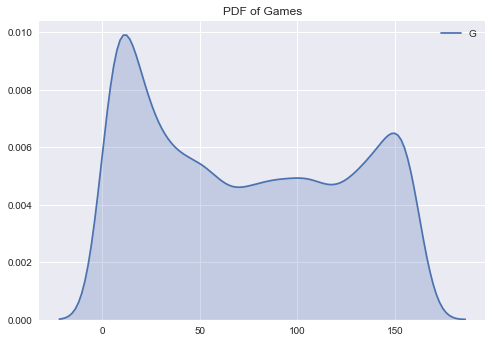

In [456]:
sns.kdeplot(batting_1985.G, shade=True)
plt.title("PDF of Games")
plt.show()

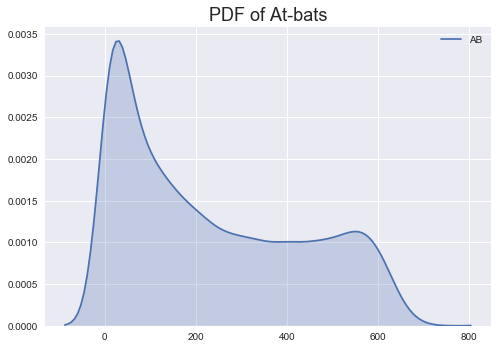

In [233]:
sns.kdeplot(batting_1985_100g.AB, shade=True)
plt.title("PDF of At-bats")
plt.show()

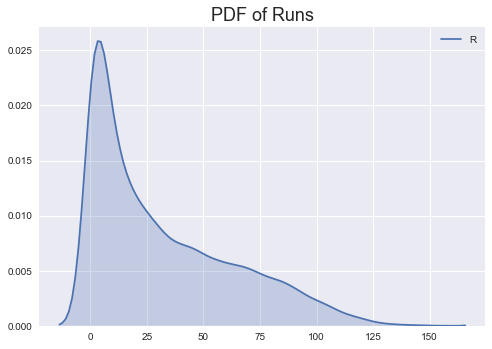

In [234]:
sns.kdeplot(batting_1985_100g.R, shade=True)
plt.title("PDF of Runs")
plt.show()

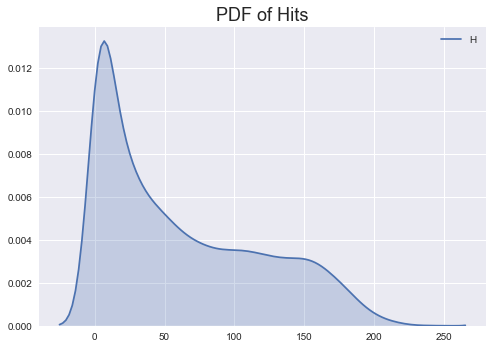

In [235]:
sns.kdeplot(batting_1985_100g.H, shade=True)
plt.title("PDF of Hits")
plt.show()

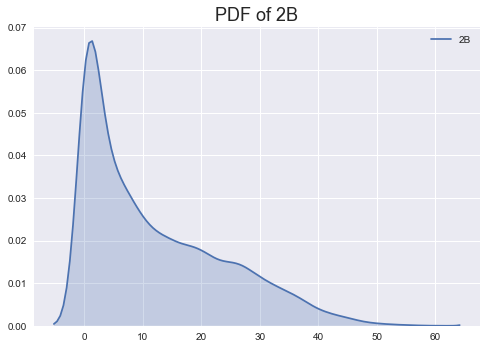

In [236]:
sns.kdeplot(batting_1985_100g['2B'], shade=True)
plt.title("PDF of 2B")
plt.show()

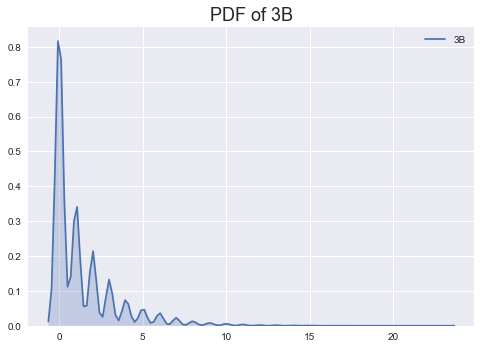

In [237]:
sns.kdeplot(batting_1985_100g['3B'], shade=True)
plt.title("PDF of 3B")
plt.show()

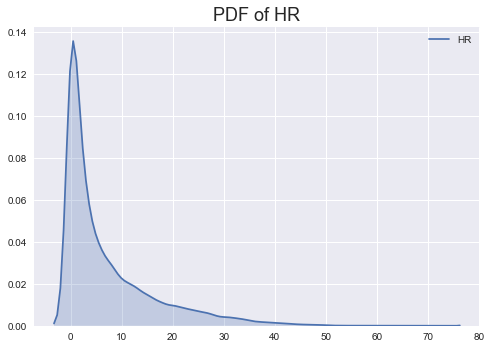

In [238]:
sns.kdeplot(batting_1985_100g.HR, shade=True)
plt.title("PDF of HR")
plt.show()

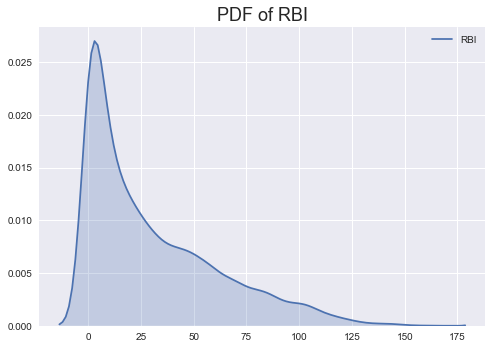

In [239]:
sns.kdeplot(batting_1985_100g.RBI, shade=True)
plt.title("PDF of RBI")
plt.show()

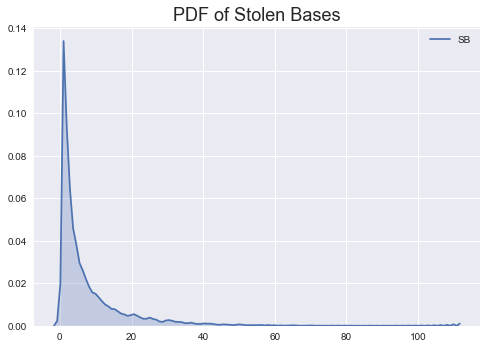

In [240]:
sns.kdeplot(batting_1985_100g.SB, shade=True)
plt.title("PDF of Stolen Bases")
plt.show()

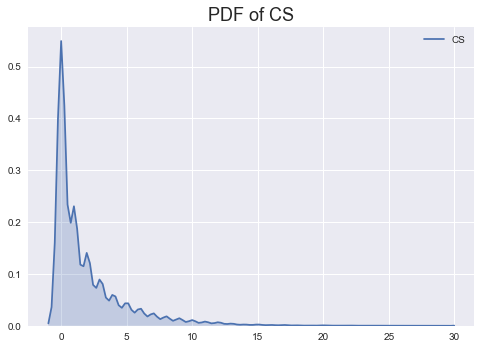

In [241]:
sns.kdeplot(batting_1985_100g.CS, shade=True)
plt.title("PDF of CS")
plt.show()

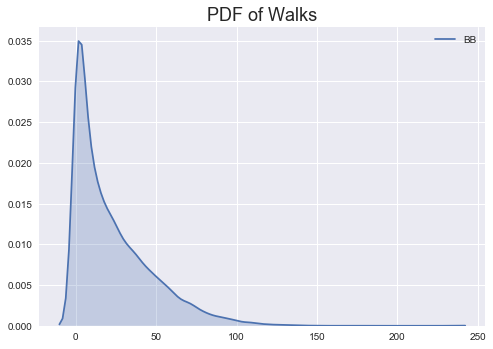

In [242]:
sns.kdeplot(batting_1985_100g.BB, shade=True)
plt.title("PDF of Walks")
plt.show()

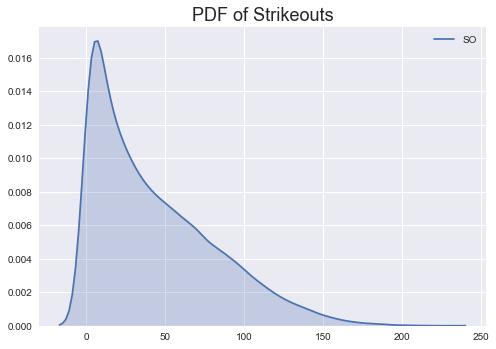

In [243]:
sns.kdeplot(batting_1985_100g.SO, shade=True)
plt.title("PDF of Strikeouts")
plt.show()

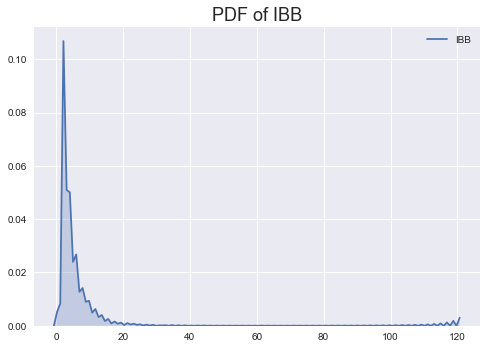

In [244]:
sns.kdeplot(batting_1985_100g.IBB, shade=True)
plt.title("PDF of IBB")
plt.show()

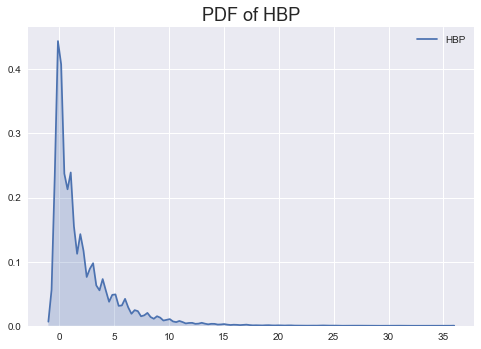

In [245]:
sns.kdeplot(batting_1985_100g.HBP, shade=True)
plt.title("PDF of HBP")
plt.show()

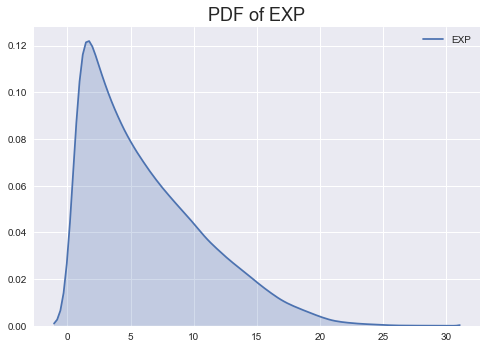

In [246]:
sns.kdeplot(batting_1985_100g.EXP, shade=True)
plt.title("PDF of EXP")
plt.show()

In [247]:
df = pd.merge(salaries, batting_1985_100g)

In [248]:
df.head()

,yearID,teamID,lgID,playerID,salary,stint,G,AB,R,H,...,CS,BB,SO,IBB,HBP,SH,SF,GIDP,_merge,EXP
0,1985,ATL,NL,benedbr01,545000,1,70,208,12,42,...,1.0,22,12.0,1.0,1.0,4.0,2.0,8.0,left_only,8
1,1985,ATL,NL,chambch01,800000,1,101,170,16,40,...,0.0,18,22.0,4.0,0.0,0.0,1.0,5.0,left_only,16
2,1985,ATL,NL,harpete01,250000,1,138,492,58,130,...,9.0,44,76.0,4.0,3.0,1.0,2.0,13.0,left_only,6
3,1985,ATL,NL,hornebo01,1500000,1,130,483,61,129,...,1.0,50,57.0,4.0,1.0,0.0,6.0,18.0,left_only,8
4,1985,ATL,NL,hubbagl01,455000,1,142,439,51,102,...,3.0,56,54.0,2.0,4.0,7.0,6.0,11.0,left_only,8


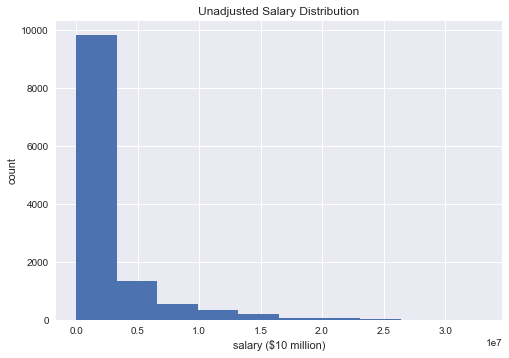

In [249]:
sns.set()
_ = plt.hist(df.salary)
plt.xlabel('salary ($10 million)')
plt.ylabel('count')
plt.title('Unadjusted Salary Distribution')
plt.show()

Plot unadjusted salary over time for the years 1985 - 2016.  Unadjusted salary is salary that is not adjusted for inflation, or is in nominal dollars.

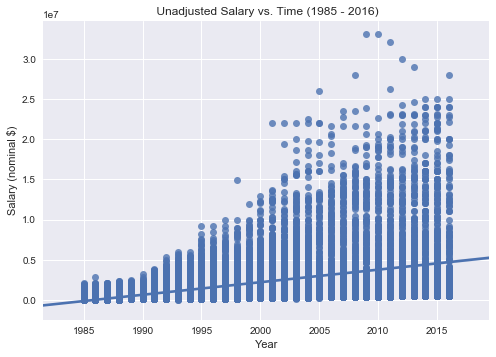

In [250]:
sns.regplot(x='yearID',
            y='salary',
           data=df)
plt.title(' Unadjusted Salary vs. Time (1985 - 2016)')
plt.xlabel('Year')
plt.ylabel('Salary (nominal $)')
plt.show()

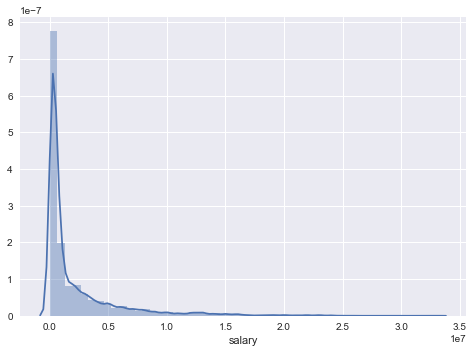

In [251]:
sns.distplot(df.salary)
plt.show()

There are rows that have zeros for the salary.  Remove these observations.  The lowest minimum salary in current year dollars was in 1985.  It was 60,000.  Remove the observations where the salary is less than 60,000.

In [252]:
df_clean1 = df[df.salary !=0]
df_clean2 = df_clean1[df_clean1.salary >= 60000]
df_clean2.head()

,yearID,teamID,lgID,playerID,salary,stint,G,AB,R,H,...,CS,BB,SO,IBB,HBP,SH,SF,GIDP,_merge,EXP
0,1985,ATL,NL,benedbr01,545000,1,70,208,12,42,...,1.0,22,12.0,1.0,1.0,4.0,2.0,8.0,left_only,8
1,1985,ATL,NL,chambch01,800000,1,101,170,16,40,...,0.0,18,22.0,4.0,0.0,0.0,1.0,5.0,left_only,16
2,1985,ATL,NL,harpete01,250000,1,138,492,58,130,...,9.0,44,76.0,4.0,3.0,1.0,2.0,13.0,left_only,6
3,1985,ATL,NL,hornebo01,1500000,1,130,483,61,129,...,1.0,50,57.0,4.0,1.0,0.0,6.0,18.0,left_only,8
4,1985,ATL,NL,hubbagl01,455000,1,142,439,51,102,...,3.0,56,54.0,2.0,4.0,7.0,6.0,11.0,left_only,8


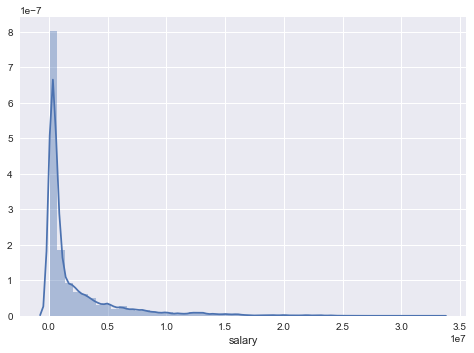

In [253]:
sns.distplot(df_clean2.salary)
plt.show()

Need to adjust salary for inflation.  For ease of interpretation, let's use 2016 dollars.  Use the CPI to calculate this.

In [254]:
cpi = pd.read_csv('CPI.csv')
cpi.head()

,yearID,CPI
0,1985,107.6
1,1986,109.6
2,1987,113.6
3,1988,118.3
4,1989,124.0


Merge the salary data and cpi data by year.  Use the CPI value to adjust salary to 2016 dollars.

In [255]:
salary_adj = pd.merge(df_clean2, cpi, how='left', on='yearID')
salary_adj.head()

,yearID,teamID,lgID,playerID,salary,stint,G,AB,R,H,...,BB,SO,IBB,HBP,SH,SF,GIDP,_merge,EXP,CPI
0,1985,ATL,NL,benedbr01,545000,1,70,208,12,42,...,22,12.0,1.0,1.0,4.0,2.0,8.0,left_only,8,107.6
1,1985,ATL,NL,chambch01,800000,1,101,170,16,40,...,18,22.0,4.0,0.0,0.0,1.0,5.0,left_only,16,107.6
2,1985,ATL,NL,harpete01,250000,1,138,492,58,130,...,44,76.0,4.0,3.0,1.0,2.0,13.0,left_only,6,107.6
3,1985,ATL,NL,hornebo01,1500000,1,130,483,61,129,...,50,57.0,4.0,1.0,0.0,6.0,18.0,left_only,8,107.6
4,1985,ATL,NL,hubbagl01,455000,1,142,439,51,102,...,56,54.0,2.0,4.0,7.0,6.0,11.0,left_only,8,107.6


In [256]:
salary_adj['salary2016'] = (240/salary_adj.CPI)*salary_adj.salary
salary_adj.head()

,yearID,teamID,lgID,playerID,salary,stint,G,AB,R,H,...,SO,IBB,HBP,SH,SF,GIDP,_merge,EXP,CPI,salary2016
0,1985,ATL,NL,benedbr01,545000,1,70,208,12,42,...,12.0,1.0,1.0,4.0,2.0,8.0,left_only,8,107.6,1.215613e+06
1,1985,ATL,NL,chambch01,800000,1,101,170,16,40,...,22.0,4.0,0.0,0.0,1.0,5.0,left_only,16,107.6,1.784387e+06
2,1985,ATL,NL,harpete01,250000,1,138,492,58,130,...,76.0,4.0,3.0,1.0,2.0,13.0,left_only,6,107.6,5.576208e+05
3,1985,ATL,NL,hornebo01,1500000,1,130,483,61,129,...,57.0,4.0,1.0,0.0,6.0,18.0,left_only,8,107.6,3.345725e+06
4,1985,ATL,NL,hubbagl01,455000,1,142,439,51,102,...,54.0,2.0,4.0,7.0,6.0,11.0,left_only,8,107.6,1.014870e+06


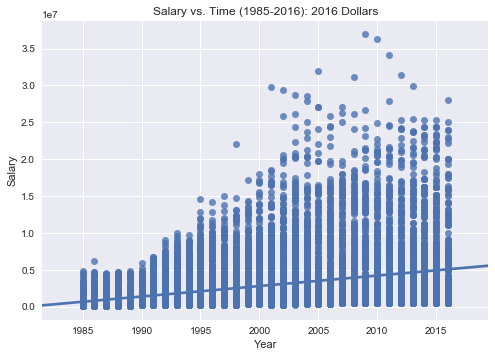

In [257]:
sns.regplot(x='yearID',
            y='salary2016',
            data=salary_adj)
plt.title('Salary vs. Time (1985-2016): 2016 Dollars')
plt.ylabel('Salary')
plt.xlabel('Year')
plt.show()

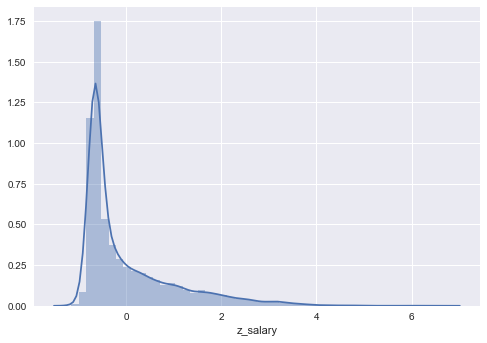

In [258]:
salary_adj['mean_salary'] = salary_adj['salary2016'].groupby(salary_adj['yearID']).transform('mean')
salary_adj['std_salary'] = salary_adj['salary2016'].groupby(salary_adj['yearID']).transform('std')
salary_adj.head()

salary_adj['z_salary'] = (salary_adj.salary2016 - salary_adj.mean_salary)/salary_adj.std_salary
salary_adj.head()

# plot z-scores for salary distribution
sns.distplot(salary_adj.z_salary)
plt.show()

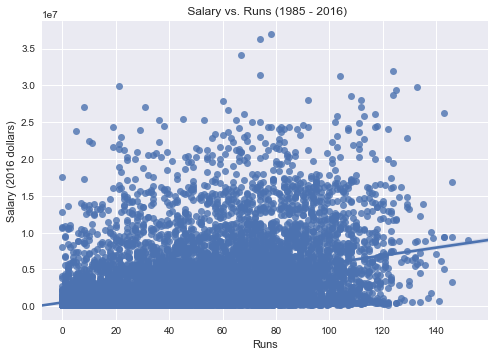

In [259]:
sns.regplot(x='R',
            y='salary2016',
           data=salary_adj)
plt.title(' Salary vs. Runs (1985 - 2016)')
plt.xlabel('Runs')
plt.ylabel('Salary (2016 dollars)')
plt.show()

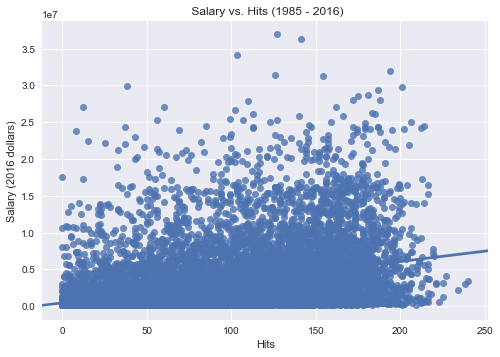

In [260]:
sns.regplot(x='H',
            y='salary2016',
           data=salary_adj)
plt.title(' Salary vs. Hits (1985 - 2016)')
plt.xlabel('Hits')
plt.ylabel('Salary (2016 dollars)')
plt.show()

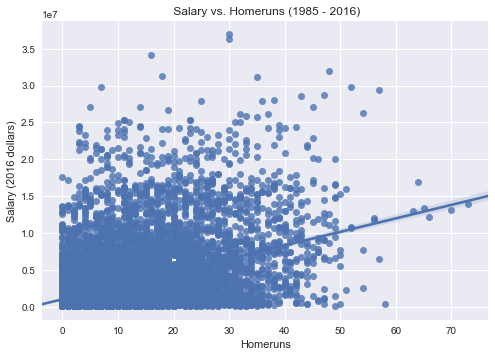

In [261]:
sns.regplot(x='HR',
            y='salary2016',
           data=salary_adj)
plt.title(' Salary vs. Homeruns (1985 - 2016)')
plt.xlabel('Homeruns')
plt.ylabel('Salary (2016 dollars)')
plt.show()

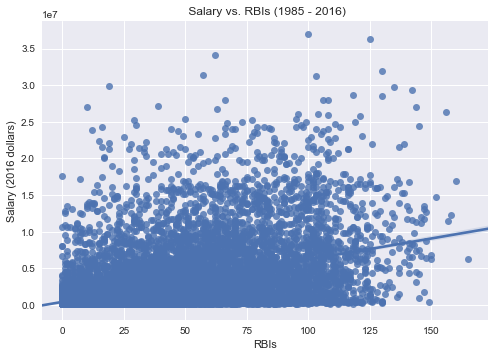

In [262]:
sns.regplot(x='RBI',
            y='salary2016',
           data=salary_adj)
plt.title(' Salary vs. RBIs (1985 - 2016)')
plt.xlabel('RBIs')
plt.ylabel('Salary (2016 dollars)')
plt.show()

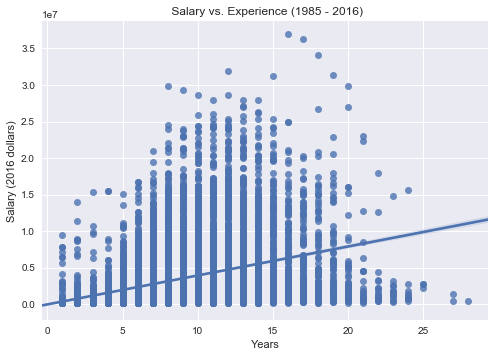

In [263]:
sns.regplot(x='EXP',
            y='salary2016',
           data=salary_adj)
plt.title(' Salary vs. Experience (1985 - 2016)')
plt.xlabel('Years')
plt.ylabel('Salary (2016 dollars)')
plt.show()

Create a batting average feature, which is simply the number hits a player has divided by the number of at-bats.  Also, create the log of salary.

In [264]:

salary_adj['AVG'] = salary_adj.H / salary_adj.AB *1000
salary_adj['log_salary2016'] = np.log(salary_adj['salary2016'])
salary_adj['EXP_SQ']=np.square(salary_adj['EXP'])

salary_adj.sort_values(by=['playerID', 'yearID'])




,yearID,teamID,lgID,playerID,salary,stint,G,AB,R,H,...,_merge,EXP,CPI,salary2016,mean_salary,std_salary,z_salary,AVG,log_salary2016,EXP_SQ
8506,2006,CIN,NL,abadan01,327000,1,5,3,0,0,...,left_only,3,201.6,3.892857e+05,3.848380e+06,4.977672e+06,-0.694922,0.000000,12.872069,9
5147,1998,CHA,AL,abbotje01,175000,1,89,244,33,68,...,left_only,2,163.0,2.576687e+05,2.120826e+06,2.989545e+06,-0.623224,278.688525,12.459430,4
5628,1999,CHA,AL,abbotje01,255000,1,17,57,5,9,...,left_only,3,166.6,3.673469e+05,2.265979e+06,3.091555e+06,-0.614135,157.894737,12.814062,9
6096,2000,CHA,AL,abbotje01,255000,1,80,215,31,59,...,left_only,4,172.2,3.554007e+05,3.030655e+06,3.679262e+06,-0.727117,274.418605,12.781001,16
6587,2001,FLO,NL,abbotje01,300000,1,28,42,5,11,...,left_only,5,177.1,4.065500e+05,3.388693e+06,4.257288e+06,-0.700480,261.904762,12.915462,25
3121,1993,OAK,AL,abbotku01,109000,1,20,61,11,15,...,left_only,1,144.5,1.810381e+05,1.661138e+06,2.153130e+06,-0.687418,245.901639,12.106463,1
3417,1994,FLO,NL,abbotku01,109000,1,101,345,41,86,...,left_only,2,148.2,1.765182e+05,1.747477e+06,2.194708e+06,-0.715794,249.275362,12.081179,4
3863,1995,FLO,NL,abbotku01,119000,1,120,420,60,107,...,left_only,3,152.4,1.874016e+05,1.678821e+06,2.600248e+06,-0.573568,254.761905,12.141009,9
4334,1996,FLO,NL,abbotku01,250000,1,109,320,37,81,...,left_only,4,156.9,3.824092e+05,1.776882e+06,2.589173e+06,-0.538579,253.125000,12.854246,16
4783,1997,FLO,NL,abbotku01,650000,1,94,252,35,69,...,left_only,5,160.5,9.719626e+05,2.103988e+06,2.835857e+06,-0.399183,273.809524,13.787073,25


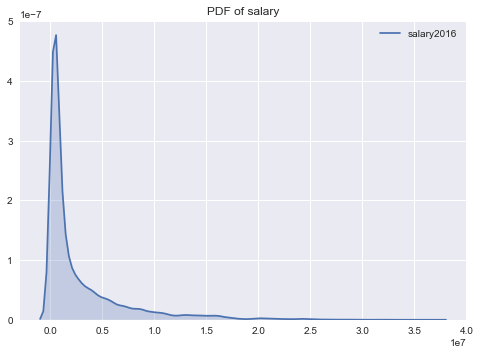

In [265]:
sns.kdeplot(salary_adj.salary2016, shade=True)
plt.title("PDF of salary")
plt.show()

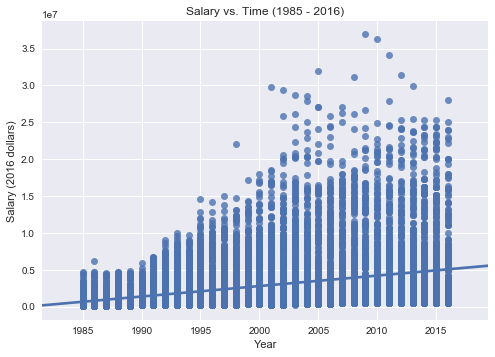

In [266]:
sns.regplot(x='yearID',
            y='salary2016',
           data=salary_adj)
plt.title('Salary vs. Time (1985 - 2016)')
plt.xlabel('Year')
plt.ylabel('Salary (2016 dollars)')
plt.show()

Creating lagged values of the target variable and lagged values of the features.  This is based on the idea that salary is based off of past performance.

In [395]:
# lagged values of salary
salary_adj['sal_t_1'] = salary_adj.groupby(['playerID'])['salary2016'].shift(1)
salary_adj['sal_t_2'] = salary_adj.groupby(['playerID'])['salary2016'].shift(2)
salary_adj['sal_t_3'] = salary_adj.groupby(['playerID'])['salary2016'].shift(3)

# first difference of salary lagged one period
salary_adj['sal_diff'] = salary_adj.salary2016 - salary_adj.sal_t_1
salary_adj['sal_diff_t_1'] = salary_adj.groupby(['playerID'])['sal_diff'].shift(1)

# lagged values of the features
salary_adj['G_t_1'] = salary_adj.groupby(['playerID'])['G'].shift(1)
salary_adj['G_t_2'] = salary_adj.groupby(['playerID'])['G'].shift(2)

salary_adj['AB_t_1'] = salary_adj.groupby(['playerID'])['AB'].shift(1)
salary_adj['AB_t_2'] = salary_adj.groupby(['playerID'])['AB'].shift(2)

salary_adj['R_t_1'] = salary_adj.groupby(['playerID'])['R'].shift(1)
salary_adj['R_t_2'] = salary_adj.groupby(['playerID'])['R'].shift(2)

salary_adj['H_t_1'] = salary_adj.groupby(['playerID'])['H'].shift(1)
salary_adj['H_t_2'] = salary_adj.groupby(['playerID'])['H'].shift(2)

salary_adj['2B_t_1'] = salary_adj.groupby(['playerID'])['2B'].shift(1)
salary_adj['2B_t_2'] = salary_adj.groupby(['playerID'])['2B'].shift(2)

salary_adj['3B_t_1'] = salary_adj.groupby(['playerID'])['3B'].shift(1)
salary_adj['3B_t_2'] = salary_adj.groupby(['playerID'])['3B'].shift(2)

salary_adj['HR_t_1'] = salary_adj.groupby(['playerID'])['HR'].shift(1)
salary_adj['HR_t_2'] = salary_adj.groupby(['playerID'])['HR'].shift(2)

salary_adj['RBI_t_1'] = salary_adj.groupby(['playerID'])['RBI'].shift(1)
salary_adj['RBI_t_2'] = salary_adj.groupby(['playerID'])['RBI'].shift(2)

salary_adj['AVG_t_1'] = salary_adj.groupby(['playerID'])['AVG'].shift(1)
salary_adj['AVG_t_2'] = salary_adj.groupby(['playerID'])['AVG'].shift(2)

salary_adj.sort_values(by=['playerID', 'yearID'])

,yearID,teamID,lgID,playerID,salary,stint,G,AB,R,H,...,HR_t_2,RBI_t_1,RBI_t_2,AVG_t_1,AVG_t_2,sal_diff,sal_diff_t_1,OBP,OBP_t_1,sal_t_3
8506,2006,CIN,NL,abadan01,327000,1,5,3,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.400000,NaN,NaN
5147,1998,CHA,AL,abbotje01,175000,1,89,244,33,68,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.298450,NaN,NaN
5628,1999,CHA,AL,abbotje01,255000,1,17,57,5,9,...,NaN,41.0,NaN,278.688525,NaN,1.096782e+05,NaN,0.222222,0.298450,NaN
6096,2000,CHA,AL,abbotje01,255000,1,80,215,31,59,...,12.0,6.0,41.0,157.894737,278.688525,-1.194624e+04,1.096782e+05,0.343096,0.222222,NaN
6587,2001,FLO,NL,abbotje01,300000,1,28,42,5,11,...,2.0,29.0,6.0,274.418605,157.894737,5.114927e+04,-1.194624e+04,0.326087,0.343096,2.576687e+05
3121,1993,OAK,AL,abbotku01,109000,1,20,61,11,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.281250,NaN,NaN
3417,1994,FLO,NL,abbotku01,109000,1,101,345,41,86,...,NaN,9.0,NaN,245.901639,NaN,-4.519844e+03,NaN,0.290761,0.281250,NaN
3863,1995,FLO,NL,abbotku01,119000,1,120,420,60,107,...,3.0,33.0,9.0,249.275362,245.901639,1.088336e+04,-4.519844e+03,0.317597,0.290761,NaN
4334,1996,FLO,NL,abbotku01,250000,1,109,320,37,81,...,9.0,60.0,33.0,254.761905,249.275362,1.950076e+05,1.088336e+04,0.307246,0.317597,1.810381e+05
4783,1997,FLO,NL,abbotku01,650000,1,94,252,35,69,...,17.0,33.0,60.0,253.125000,254.761905,5.895534e+05,1.950076e+05,0.314607,0.307246,1.765182e+05


On Base Percentage (aka OBP, On Base Average, OBA) is a measure of how often a batter reaches base. It is approximately equal to Times on Base/Plate appearances.

The full formula is OBP = (Hits + Walks + Hit by Pitch) / (At Bats + Walks + Hit by Pitch + Sacrifice Flies). Batters are not credited with reaching base on an error or fielder's choice, and they are not charged with an opportunity if they make a sacrifice bunt.

In [396]:
salary_adj['OBP'] = (salary_adj.H + salary_adj.BB + salary_adj.HBP)/(salary_adj.AB + salary_adj.BB + salary_adj.HBP
                                                                    + salary_adj.SF)

# Create lagged value of OBP
salary_adj['OBP_t_1'] = salary_adj.groupby(['playerID'])['OBP'].shift(1)

In [506]:
# Dummy variable for first year off of league minimum (4th season in the league)
#salary_adj['fourth_season'] = salary_adj[

# Dummy variable for first year off of arbitration (7th season in the league)

In [507]:
salary_adj.describe()

,yearID,salary,stint,G,AB,R,H,2B,3B,HR,...,HR_t_2,RBI_t_1,RBI_t_2,AVG_t_1,AVG_t_2,sal_diff,sal_diff_t_1,OBP,OBP_t_1,sal_t_3
count,12410.000000,1.241000e+04,12410.000000,12410.000000,12410.000000,12410.000000,12410.000000,12410.000000,12410.000000,12410.000000,...,8401.000000,10167.000000,8401.000000,10161.000000,8396.000000,1.016700e+04,8.401000e+03,12396.000000,10161.000000,6.941000e+03
mean,2000.337228,2.265494e+06,1.006366,96.380177,314.106124,43.300725,84.171313,16.317002,1.813376,9.647059,...,11.725747,46.252975,49.519581,259.937998,263.482770,3.660251e+05,4.862098e+05,0.319551,0.327565,2.981229e+06
std,8.805048,3.695309e+06,0.085398,46.013323,189.907677,31.432644,56.065237,11.863859,2.311327,10.052021,...,10.613637,31.597000,31.973678,46.826592,44.696698,1.876675e+06,1.788150e+06,0.062490,0.054015,4.254068e+06
min,1985.000000,6.000000e+04,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-2.164086e+07,-2.164086e+07,0.000000,0.000000,1.267963e+05
25%,1993.000000,3.000000e+05,1.000000,59.000000,144.000000,16.000000,34.000000,6.000000,0.000000,2.000000,...,3.000000,21.000000,24.000000,239.436620,243.112930,-5.383169e+02,1.021327e+04,0.293333,0.301587,3.898810e+05
50%,2000.000000,6.197225e+05,1.000000,102.000000,310.000000,38.000000,79.000000,15.000000,1.000000,6.000000,...,9.000000,42.000000,46.000000,263.440860,266.666667,1.163677e+05,1.520510e+05,0.324436,0.329897,1.030675e+06
75%,2008.000000,2.550000e+06,1.000000,138.000000,484.000000,67.000000,131.000000,25.000000,3.000000,14.000000,...,18.000000,67.000000,71.000000,286.445013,288.736132,7.998125e+05,9.460236e+05,0.354244,0.358098,4.002223e+06
max,2016.000000,3.300000e+07,3.000000,163.000000,716.000000,152.000000,240.000000,59.000000,23.000000,73.000000,...,73.000000,165.000000,165.000000,1000.000000,1000.000000,2.373353e+07,2.373353e+07,1.000000,1.000000,3.692308e+07


In [508]:
y = salary_adj.salary2016
# x = salary_adj[['G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF',
#               'GIDP', 'AVG', 'EXP', 'sal_t_1', 'G_t_1', 'AB_t_1', 'R_t_1', 'H_t_1', '2B_t_1', '3B_t_1', 
#                'HR_t_1', 'RBI_t_1', 'AVG_t_1', 'sal_t_2', 'sal_t_3', 'OBP', 'OBP_t_1']]

x = salary_adj[['EXP', 'EXP_SQ', 'sal_t_1', 'G_t_1', 'AB_t_1', 'R_t_1', 'H_t_1', '2B_t_1', '3B_t_1', 
                'HR_t_1', 'RBI_t_1', 'AVG_t_1', 'sal_t_2', 'sal_t_3', 'OBP_t_1']]

Create the training and test splits.

In [509]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=66)

In [510]:
X_train.head()

,EXP,EXP_SQ,sal_t_1,G_t_1,AB_t_1,R_t_1,H_t_1,2B_t_1,3B_t_1,HR_t_1,RBI_t_1,AVG_t_1,sal_t_2,sal_t_3,OBP_t_1
8505,13,169,3.072197e+06,110.0,397.0,50.0,121.0,25.0,3.0,12.0,40.0,304.785894,2.223399e+06,4.500000e+06,0.354988
2797,13,169,1.541850e+06,34.0,111.0,11.0,23.0,6.0,0.0,5.0,20.0,207.207207,1.514920e+06,1.741935e+06,0.288000
6414,11,121,2.881152e+06,96.0,195.0,37.0,51.0,6.0,0.0,5.0,24.0,261.538462,1.840491e+06,1.345794e+06,0.397541
2667,7,49,2.202643e+06,124.0,418.0,58.0,108.0,23.0,0.0,4.0,51.0,258.373206,7.253252e+05,3.290323e+05,0.378431
7403,4,16,8.004447e+05,152.0,592.0,90.0,170.0,20.0,5.0,1.0,35.0,287.162162,2.913608e+05,NaN,0.332278


## XGBoost Models

In [511]:
import xgboost as xgb

In [512]:
# First XGBoost model for Batting Salary dataset

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
kfold = KFold(n_splits=10, random_state=7)

model_xgb = XGBRegressor(objective='reg:linear',
                         n_estimators=100,
                         max_depth=4,
                         learning_rate = 0.08,
                         nthreads=-1,
                         seed=123,
                         eval_metric="rmse")
results = cross_val_score(model_xgb, X_train, y_train, cv=kfold)
print(results)
model_xgb.fit(X_train, y_train)


# make predictions for test data
y_pred = model_xgb.predict(X_test)
print("Score_XGB:", model_xgb.score(X_test, y_test))

[0.86647812 0.86840589 0.84028272 0.87774066 0.8949435  0.82553531
 0.86481696 0.879739   0.89845301 0.87177873]
Score_XGB: 0.8609105554840649


In [442]:
 import scipy.stats as st

one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

params = {  
    "n_estimators": st.randint(3, 500),
    "max_depth": st.randint(3, 50),
    "learning_rate": st.uniform(0.01, 0.4),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive,
}

xgbreg = XGBRegressor(objective='reg:linear', nthreads=-1)  

from sklearn.model_selection import RandomizedSearchCV

gs = RandomizedSearchCV(xgbreg, params, n_jobs=1)  
gs.fit(X_train, y_train)
print("Score_XGB:", gs.score(X_test, y_test))



Score_XGB: 0.8602016518958693


In [499]:
residual = y_test - y_pred

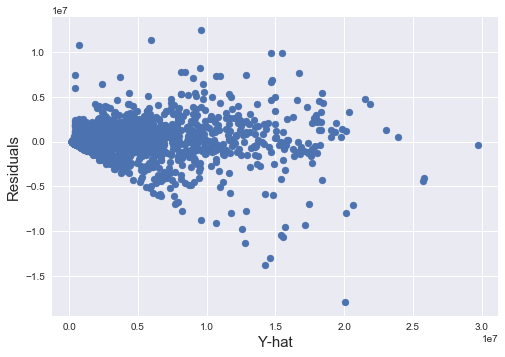

In [500]:
plt.scatter(y_pred, residual)
plt.xlabel('Y-hat')
plt.ylabel('Residuals')
plt.show()

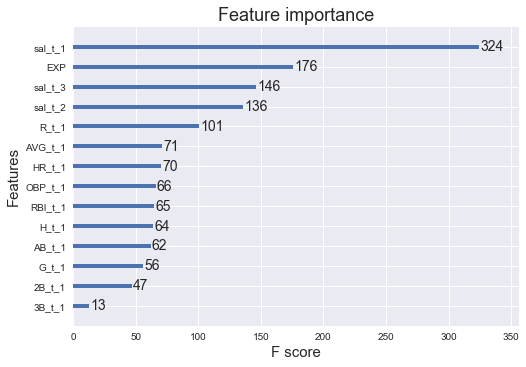

In [501]:
xgb.plot_importance(model_xgb)

In [451]:
gs.predict(X_test)

array([371592.12, 650945.3 , 375030.22, ..., 311461.72, 375030.22,
       808960.9 ], dtype=float32)

Text(0,0.5,'Residuals')

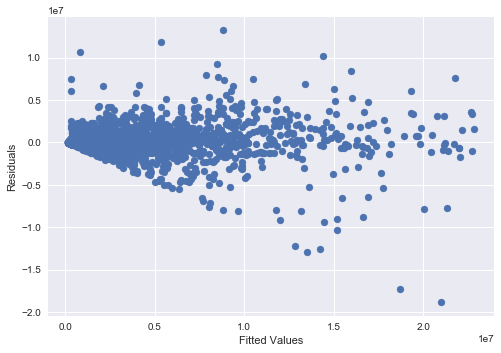

In [452]:
y_pred_gs = gs.predict(X_test)
res_gs = y_test - y_pred_gs
plt.scatter(y_pred_gs, res_gs)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')